In [285]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [286]:
data = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
print(data.shape)

(1470, 35)


In [287]:
# Drop Columns Which make no impact on Attrition
data.drop(columns=["Over18",'EmployeeCount', 'EmployeeNumber','StandardHours'], inplace=True)
print(data.shape)

(1470, 31)


In [288]:
## Boolean Variables Mapping
# Mapping Attrition values to 0&1
data['Attrition'] = data['Attrition'].map({'Yes': 1, 'No': 0})

# Mapping OverTime values to 0&1
data['OverTime'] = data['OverTime'].map({'Yes': 1, 'No': 0})

In [289]:
# Columns that droped by seeing feature importance curve and analyzing classification report.
# you can comment out this block at first,and see step by step again commenting in to see improvement of model
data.drop(columns=['Department','EducationField','MaritalStatus','HourlyRate','JobLevel','PerformanceRating','MonthlyRate','DailyRate'], inplace=True)

print(data.shape)

(1470, 23)


In [290]:
# Seperate category/text and Numerical Columns 
categorical_columns = []
numerical_columns = []
for col in data:
    if data[col].dtype == object:
        categorical_columns.append(col)
    else :
        numerical_columns.append(col)

numerical_columns.remove("Attrition")                        # Beacause, it is target.

In [291]:
print(categorical_columns)
print(numerical_columns)

['BusinessTravel', 'Gender', 'JobRole']
['Age', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobSatisfaction', 'MonthlyIncome', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


In [292]:
# Features and Target selection
features = numerical_columns + categorical_columns

X = data[features]
y = data['Attrition'].values                                    # .values → converts the pandas column to a NumPy array

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.2,random_state= 42)

In [293]:
def one_hot_encode(train, test, column_name):
    # Encode only the given column, preserve all other columns
    train_encoded = pd.get_dummies(train, columns=[column_name], drop_first=True)
    test_encoded = pd.get_dummies(test, columns=[column_name], drop_first=True)
    
    # Align columns to avoid mismatch between train and test
    test_encoded = test_encoded.reindex(columns=train_encoded.columns, fill_value=0)
    
    return train_encoded, test_encoded

# Encode Categorical Columns
for col in categorical_columns:
    X_train, X_test = one_hot_encode(X_train, X_test, col)
print(X_train.shape,X_test.shape)

(1176, 30) (294, 30)


In [294]:
print("y_test -->")
print(f'0s : {y_test.shape[0] - np.count_nonzero(y_test)}')
print(f'1s : {np.count_nonzero(y_test)}')
# Both classes are not well balanced.Thus Accuracy will not give "Perfect" tag to the model
# we have to compute mode based on precision and recall(mainly recall for this example)

y_test -->
0s : 255
1s : 39


In [295]:
# Scale the features(Scaling does matter much in logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training the Model
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)


# APPLYING THRESHOLD TO INCREASE RECALL

y_prob = log_model.predict_proba(X_test_scaled)[:, 1]                 # it will give predicted probabilities for class 1
threshold = 0.15                                                       # Apply threshold
y_pred_custom = (y_prob >= threshold).astype(int)

print(classification_report(y_test, y_pred_custom))

              precision    recall  f1-score   support

           0       0.95      0.77      0.85       255
           1       0.33      0.74      0.46        39

    accuracy                           0.77       294
   macro avg       0.64      0.76      0.65       294
weighted avg       0.87      0.77      0.80       294



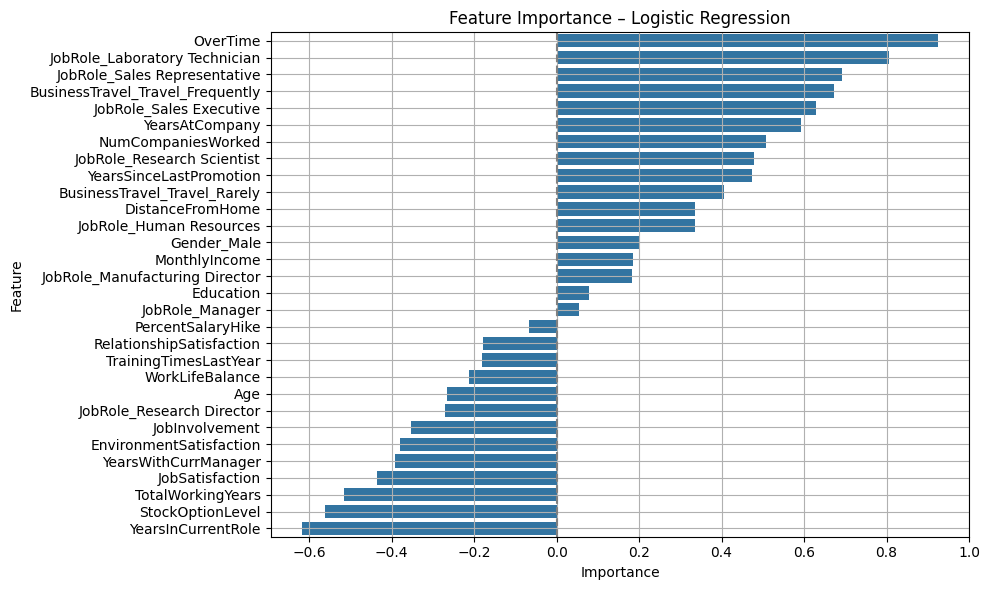

In [296]:
# Get feature importance (coefficients)
importance = log_model.coef_[0]  # for binary classification

# Combine with feature names
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance
})

# Sort by absolute importance
feature_importance['AbsImportance'] = feature_importance['Importance'].abs()
feature_importance = feature_importance.sort_values(by='AbsImportance', ascending=False)

# Drop the helper column
feature_importance.drop(columns='AbsImportance', inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=feature_importance.sort_values(by='Importance', ascending=False),
    x='Importance',
    y='Feature'
)
plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.grid(True)
plt.title("Feature Importance – Logistic Regression")
plt.show()